Dont drop nans, no linear regression, train & test 2 different files, 
get dummies & standard scalars, sklearn pipelines to do sequence of transformations
random forests dont care bout nans, data is a mess

Shit to do: 
just work on 10% of the data
figure out pipelines https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [ ]:
# Instantiating DFs for both training and holdout data

farm_train = pd.read_csv('data/Train.zip')

farm_test = pd.read_csv('data/Holdout.zip')



'''
making two new columns for the log transformation 
of SalePrice for train and test
'''


farm_train['SalePricelog'] = np.log(farm_train['SalePrice'])
farm_test['SalePricelog'] = np.log(farm_train['SalePrice'])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Checking to ensure transformation worked

farm_train[['SalePrice', 'SalePricelog']].head()

,SalePrice,SalePricelog
0,66000,11.097410
1,57000,10.950807
2,10000,9.210340
3,38500,10.558414
4,11000,9.305651


In [ ]:
farm_train.drop(['SalePrice','SalesID'], axis = 1,inplace = True)

In [ ]:
farm_train['UsageBand'].value_counts()

Medium    33985
Low       23620
High      12034
Name: UsageBand, dtype: int64

In [ ]:
farm_train['fiSecondaryDesc'].value_counts()

C         43235
B         39203
G         36424
H         24050
E         21048
          ...  
BLGPPS        1
MSR           1
R-2           1
DC            1
SF            1
Name: fiSecondaryDesc, Length: 175, dtype: int64

Potentially usefull columns with missing values:

auctioneerID, MachineHoursCurrentMeter, UsageBand, fiSecondaryDesc, fiModelSeries,

ProductSize, Drive_System, Enclosure, Forks, Pad_Type, Ride_Control, Stick,

ransmission, Turbocharged, Blade_ExtensionBlade Width

In [ ]:
#  Changing yes no and not specified to numeric values
# def yes_no(x):
#     if x == 'No':
#         return -1
#     elif x == 'Yes':
#         return 1
#     else:
#         return 0


# farm_train[['Forks', 'Ride_Control', 'Turbocharged', 
#             'Blade_Extension', 'Pattern_Changer', 
#             'Pushblock', 'Scarifier', 'Coupler_System', 
#             'Backhoe_Mounting', 'Grouser_Tracks', 
#             'Pattern_Changer']].apply(yes_no, axis=1)

In [ ]:
# Used to get visual of strange columns that are not easily grouped
df_coldropper = farm_train.iloc[:, 7:39]
df_coldropper = df_coldropper.drop(['Enclosure', 'ProductGroup', 'ProductGroupDesc', 'saledate', 'fiModelDesc', 'fiBaseModel', 'fiProductClassDesc', 'state', 'Hydraulics'], axis=1)
for col in df_coldropper.columns:
    print(f"{col} Unique Values: {df_coldropper[col].unique()}" + "\n")

fiSecondaryDesc Unique Values: ['D' 'F' nan 'G' 'E' 'HAG' 'B' 'NX' 'SUPER K' 'STD' 'BL' 'Z' 'C' 'XT' 'A'
 'H' 'MR' 'PT' 'L' 'M' 'J' 'SE' 'SXT' 'HD' 'LC' 'SUPER M' 'LX' 'SUPER L'
 'LE' 'K' 'S' 'R' 'P' 'SG' 'US' 'UU' 'WX' 'PX' 'N' 'ZTM' 'SUPER E' 'XL'
 'MXT' 'EX' '-2' 'LCM' 'GT' 'TM' 'HZ' 'AX' 'DXT' '3' 'SR' '7' 'ZTS'
 'B     ' 'T' 'UR' '-3' 'V' 'ZT' '1' 'SUPER M PLUS' 'BZD' 'DZ' 'WD' 'LGP'
 'SRLC' 'CH' 'CS' 'M      ' 'ZHS G' 'Q' 'MRX' 'FR' 'UNA' 'R-2' 'PS' 'AG'
 'URG' 'NE' 'U' '2' 'SB' 'TX' 'TTL' 'JX' 'LT' 'MSR SPIN ACE' 'HF' 'HDSL'
 'LCD' 'X' 'LS' 'EST' 'LR' 'TC' 'BLGP' 'USR' 'RC' 'SJ' 'ZF' 'SUPER LE'
 'MT' 'SUPER R' 'C      ' 'BEC' 'DC' 'CE' 'AB' 'MU' 'USRK' 'W' '-7' 'SL'
 'SU' '0.7' 'THF' 'ZX' 'NL' 'CX' 'SRDZ' 'H90' 'AW' 'SP' 'EL' 'PL' '#NAME?'
 'ESS' 'CM' 'CL' 'EW' 'ZHS' 'CR' 'CKB' 'CK' 'DX' 'SX' 'HL' 'HDS' 'DT'
 'LCH' '5' 'H      ' 'SUPER' 'IV' 'XP' 'LD' 'LC7A' 'SF' 'PG' 'SPIN ACE'
 'HX' 'EG' 'HLGP' 'WT' 'XLT' 'MSR' 'BLGPPS' 'AA' 'BZ' 'TP' 'CLR' 'MC'
 'HLS' 'DL' 'USBL' 'LCLR' 'LC7L

Extract numbers from these columns:
Tire_Size, Blade_Width 

In [ ]:
farm_train.head(1)

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SalePricelog
0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,11.09741


In [ ]:
#selecting only cols with 1 data type and not equal to object
cols_with_1_dtype = []
for col in farm_train.columns:
    if (farm_train[col].apply(type).value_counts().shape[0]==1) and farm_train[col].dtype != object:
        cols_with_1_dtype.append(col)

In [ ]:
cols_with_1_dtype


['MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'SalePricelog']

In [ ]:
farm_train_quarter_janky = farm_train.head(5000)[cols_with_1_dtype].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(farm_train_quarter_janky.drop(['SalePricelog'],axis = 1).values, farm_train_quarter_janky['SalePricelog'].values)

In [ ]:
def calc_cv(estimator, Xn, Xt, yn, yt):
    MSE = cross_val_score(estimator,Xn,yn,scoring = 'neg_mean_squared_error').mean()
    R2 = cross_val_score(estimator,Xn,yn,scoring = 'r2').mean()
    ACC = cross_val_score(estimator,Xn,yn,scoring= 'accuracy')
    print(f'{estimator}\n Train CV | ACC: {ACC} | MSE: {-MSE} | R2: {R2}')

In [ ]:
# def print_scores(est,X,y):
#     for meth in ['accuracy','neg_mean_squared_error', 'neg_mean_squared_log_error', 'R2' ]:
#         print(f"{meth}: {est.score(X, y, scoring =)}")


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f'RMSE of Random Forest = {mean_squared_error(pred,y_test)**.5}')
#print(f"R^2 = {rf.score(X_test, y_test)}")  
# calc_cv(rf,X_train, X_test, y_train, y_test) 

RMSE of Random Forest = 0.41083558437272394


In [ ]:
gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print(f'RMSE of Gradient Boosting = {mean_squared_error(pred,y_test)**.5}')
#print(f"R^2 = {gb.score(X_test, y_test)}")  
# calc_cv(gb,X_train, X_test, y_train, y_test) 

RMSE of Gradient Boosting = 0.44023668247484227


In [ ]:
# forest_pipline = Pipeline([('Scale', StandardScaler()), ('model', RandomForestRegressor(random_state=0)])

# gradient_boosted_pipeline = Pipeline([('Scale', StandardScaler()), ('model', GradientBoostingRegressor(random_state=0))])

# grid = ('grid search', gridsearchCV())








In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Defining various parameters for the GridSearchCV


# Random Forest
grid_forest_params = [{'n_estimators': [50, 100, 200],   # 400, 800, 1000
                       'criterion':['mse'],
                       'max_depth':[None, 1],
                       'min_samples_split':[4,5,6],
                       'min_samples_leaf':[1,2,3,4]}]



# Gradient Boosted Regressor
boosted_params = [{'learning_rate':[0.1, 0.01, 0.001], 'n_estimators':[50, 100, 200], # 400, 800, 1000
                   'subsample':[1, 0.2, 0.1], 'criterion':['friedman_mse', 'mse'], 
                   'max_depth': [2, 3]}]

In [ ]:
'''

DEFINED GRID SEARCH FOR MODELS
ONCE DATA HAS BEEN CLEANED AND VALIDATED

'''


# random forest grid search

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=0, n_jobs=-1), 
                              param_grid=grid_forest_params, scoring=['neg_mean_squared_error', 'r2'],
                              cv=5, refit=False)


# gradient boosted grid search

grid_search_boosted = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
                                   param_grid=boosted_params, scoring=['neg_mean_squared_error', 'r2'],
                                   cv=5, refit=False)

In [ ]:
# fiting models as an initial test

# grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [50, 100, 200, 400, 800, 1000], 'subsample': [1, 0.2, 0.1], 'criterion': ['friedman_mse', 'mse'], 'max_depth': [2, 3]}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=['neg_mean_squared_error', 'r2'], verbose=0)

In [ ]:
#grid_search_boosted.fit(X_train, y_train)

In [ ]:
#df.A.str.extract('(\d+)')
from sklearn.pipeline import Pipeline
hanz_Xn, hanz_Xt, hanz_yn, hanz_yt = train_test_split(farm_train.drop(['SalePricelog'],axis = 1), farm_train['SalePricelog'].values)
class replaceStr:

    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        if isinstance(X, tuple):
            X, y = X
        return self
    
    def transform(self, X, y = None):
        if isinstance(X, tuple):
            X, y = X
        # X.replace('None or Unspecified', np.NaN, inplace = True)
        X.fillna(method = 'ffill',axis = 0,inplace = True)
        X.fillna(method = 'bfill',axis = 0,inplace = True)
        
        # X.replace('Yes', 1, inplace = True)
        # X.replace('No', -1, inplace = True)
        # for i in X.columns:
        #     if X[i].dtype == object:
                
        #         X.fillna(0,inplace = True)
        return X, y

    def fit_transform(self, X, y = None):
        return self.fit(X,y).transform(X,y)

    def __repr__(self):
        return f'Fill some NaNs or something... idk'

pipeline = Pipeline([('replaceStr', replaceStr())])
hanz_Xt, hanz_yt = pipeline.fit_transform(hanz_Xt, hanz_yt)
hanz_Xn, hanz_yn = pipeline.fit_transform(hanz_Xn, hanz_yn)
for i in hanz_X.columns:
    if hanz_Xn[i].dtype == object:
        print(i, hanz_Xn[i].unique())

UsageBand ['Low' 'High' 'Medium']
saledate ['12/13/1994 0:00' '4/25/2009 0:00' '8/25/1999 0:00' ... '5/27/2011 0:00'
 '2/28/2011 0:00' '1/22/2000 0:00']
fiModelDesc ['780D' '410E' 'D8H' ... 'KX161' 'GE142' 'PC160']
fiBaseModel ['780' '410' 'D8' ... '3725' 'WA360' 'GE142']
fiSecondaryDesc ['D' 'E' 'H' 'UR' 'P' 'G' 'L' 'C' 'F' 'K' 'B' 'N' 'SUPER K' 'R' 'BL' 'XT'
 'ZTS' 'EX' 'SE' 'M' 'LE' 'AG' 'J' 'PX' 'LC' 'Z' 'MXT' 'SUPER M' 'SUPER L'
 'A' 'Q' 'SG' '7' 'W' 'SR' 'MR' 'SUPER M PLUS' 'NX' 'UU' 'US' 'WX' 'TM'
 'LX' 'URG' 'AX' 'SRLC' 'JX' 'SP' 'U' 'ZX' 'USR' 'HD' 'S' 'SL' 'CH' 'T'
 'C      ' 'DX' 'PT' '3' 'XL' 'DZ' '1' 'WD' 'PL' 'SUPER E' 'SX' 'ZHS' 'TX'
 'B     ' 'SJ' '-2' 'SU' 'AB' 'UNA' 'ZF' 'SXT' 'LT' 'GT' 'AA' 'LCM'
 'SUPER LE' 'DXT' 'NL' 'HAG' 'MRX' 'CX' 'HZ' 'ZHS G' 'HF' '0.7' 'SB' 'LR'
 'SUPER' 'FR' 'MU' 'AW' '#NAME?' 'LGP' 'THF' 'DT' 'LCH' 'HX' '-3' 'LS'
 'PS' 'TC' 'XP' 'BZD' 'PTC' 'BEC' ' MSR SPIN ACE' 'ZT' 'CR' 'LD' 'EST'
 'XLT' 'DL' 'MT' 'V' 'LC7A' 'X' 'HDSL' 'CS' 'NLC' 'SRDZ' 'M

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(X_train, y_train)
mean_squared_error(lr.predict(X_test), y_test)**.5
# print(f"accuracy = {lr.score(X_test, y_test)}")  


0.645387829126022

In [ ]:
cols_with_1_dtype.remove('SalePricelog')

In [ ]:
cols_with_1_dtype

['MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter']

In [ ]:
X_train, y_train, X_test, y_test = farm_train[cols_with_1_dtype].values, farm_train['SalePricelog'].values, farm_test[cols_with_1_dtype].values, farm_test['SalePricelog'].values

In [ ]:
gbr = GradientBoostingRegressor(alpha=0.9, n_estimators=500, criterion='friedman_mse', init=None, 
                                learning_rate=0.1, loss='ls', max_depth=3, 
                                max_features=None, max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, min_impurity_split=None, 
                                min_samples_leaf=1, subsample=1.0, 
                                tol=0.0001, validation_fraction=0.1, verbose=0, 
                                warm_start=False)

gbr.fit(X_train, y_train)

r2_score(gbr.predict(X_test), y_test)
mean_squared_error(gbr.predict(X_test), y_test) **.5


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
def rf_score_plot(randforest, ax, X_train, y_train, X_test, y_test):
    '''
        Parameters: randforest: RandomForestRegressor
                    X_train: 2d numpy array
                    y_train: 1d numpy array
                    X_test: 2d numpy array
                    y_test: 1d numpy array

        Returns: The prediction of a random forest regressor on the test set
    '''
    randforest.fit(X_train, y_train)
    y_test_pred = randforest.predict(X_test)
    test_score = mean_squared_error(y_test, y_test_pred)
    
    ax.axhline(test_score, alpha = 0.7, c = 'y', lw=3, ls='-.', label = 
                                                        'Random Forest Test')

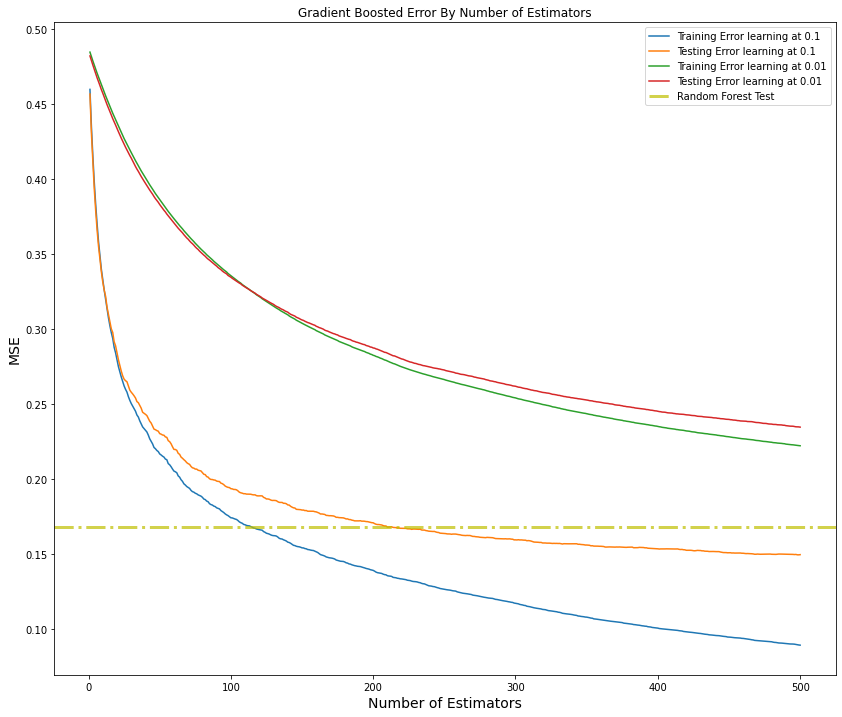

In [ ]:
# Plotting rf and gbr error rate

estimators = 500

gbr = GradientBoostingRegressor(n_estimators=estimators, learning_rate=0.1)
gbr1 = GradientBoostingRegressor(n_estimators=estimators, learning_rate=0.01)


gbr.fit(X_train, y_train)
gbr1.fit(X_train, y_train)


rf = RandomForestRegressor(n_estimators=estimators)

rf.fit(X_train, y_train)


gbr_trainscore = np.zeros(estimators)
for i, y_pred in enumerate(gbr.staged_predict(X_train)):
    gbr_trainscore[i] = mean_squared_error(y_train, y_pred)
    # gbr_trainscore[i] = gbr.loss_(y_train, y_pred)

gbr_testscore = np.zeros(estimators)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    gbr_testscore[i] = mean_squared_error(y_test, y_pred)
    # gbr_testscore[i] = grid_search_boosted.loss_(y_test, y_pred)



gbr1_trainscore = np.zeros(estimators)
for i, y_pred in enumerate(gbr1.staged_predict(X_train)):
    gbr1_trainscore[i] = mean_squared_error(y_train, y_pred)
    # gbr_trainscore[i] = gbr.loss_(y_train, y_pred)

gbr1_testscore = np.zeros(estimators)
for i, y_pred in enumerate(gbr1.staged_predict(X_test)):
    gbr1_testscore[i] = mean_squared_error(y_test, y_pred)
    # gbr_testscore[i] = grid_search_boosted.loss_(y_test, y_pred)

fig, ax = plt.subplots(figsize=(14,12))

plt.plot(np.arange(estimators) + 1, gbr_trainscore, label='Training Error learning at 0.1')
plt.plot(np.arange(estimators) + 1, gbr_testscore, label='Testing Error learning at 0.1')
plt.plot(np.arange(estimators) + 1, gbr1_trainscore, label='Training Error learning at 0.01')
plt.plot(np.arange(estimators) + 1, gbr1_testscore, label='Testing Error learning at 0.01')
rf_score_plot(rf, ax, X_train, y_train, X_test, y_test)

plt.title('Gradient Boosted Error By Number of Estimators')
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc='upper right')





Text(0.5, 1.0, 'Permutation Importances Using the Test Set')

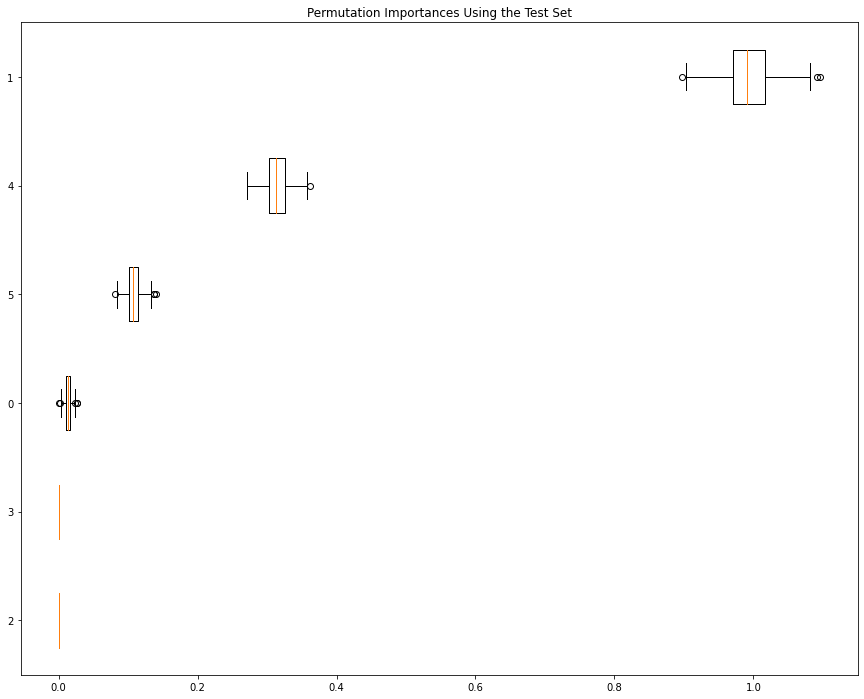

In [ ]:
result = permutation_importance(gbr, X_test, y_test, n_repeats=500,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,12))
ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=sorted_idx)

ax.set_title('Permutation Importances Using the Test Set')


In [ ]:
sorted_idx

array([2, 3, 0, 5, 4, 1])

In [ ]:
cols_with_1_dtype

['MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'SalePricelog']

In [ ]:
farm_train_quarter_janky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MachineID                 5000 non-null   int64  
 1   ModelID                   5000 non-null   int64  
 2   datasource                5000 non-null   int64  
 3   auctioneerID              5000 non-null   float64
 4   YearMade                  5000 non-null   int64  
 5   MachineHoursCurrentMeter  5000 non-null   float64
 6   SalePricelog              5000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 273.6 KB


In [ ]:
# Plotting rf and gbr error rate

estimators = 500

rf = RandomForestRegressor(n_estimators=estimators)

rf.fit(X_train, y_train)

rf_trainscore = np.zeros(estimators)
for i, y_pred in enumerate(rf.predict(X_train)):
    gbr_trainscore[i] = mean_squared_error(y_train, y_pred)
    # gbr_trainscore[i] = gbr.loss_(y_train, y_pred)

rf_testscore = np.zeros(estimators)
for i, y_pred in enumerate(rf.predict(X_test)):
    gbr_testscore[i] = mean_squared_error(y_test, y_pred)
    # gbr_testscore[i] = grid_search_boosted.loss_(y_test, y_pred)

plt.plot(np.arange(estimators) + 1, gbr_trainscore, label='Training Error')
plt.plot(np.arange(estimators) + 1, gbr_testscore, label='Testing Error')

plt.title('Random Forest Error By Number of Estimators')
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc='upper right')


TypeError: Singleton array 11.062075877900533 cannot be considered a valid collection.

In [ ]:
to_column = lambda x: x.reshape((x.shape[0], 1))
pad = .1

## Add some noise
xs = np.random.uniform(-np.pi, np.pi, estimators)
ys = f(xs) + np.random.normal(0, 0.20, estimators)

def plot_truth():
    plt.plot(x, y, linewidth = 4, color = 'black', label="True")
    plt.xlim([-np.pi-pad, np.pi+pad]); plt.ylim([-1.4, 1.4])
    
def plot_data():
    plt.plot(xs, ys, 'o', color='grey', markeredgewidth=0)

ValueError: X has 1 features, but DecisionTreeRegressor is expecting 6 features as input.

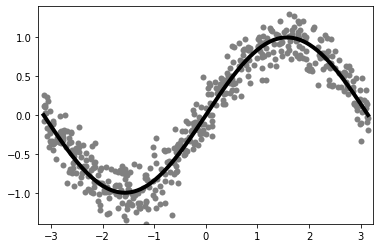

In [ ]:
plot_data(); plot_truth()

label = "Boosting Stages Over Time"
for i, pred in enumerate(gbr.staged_predict(to_column(x))):
    if i % 15 == 1:
        plt.plot(x, pred, color=plt.cm.Purples(i/1000 + 0.5),
                 linewidth=4,
                 label=label)
        label = None
        
plt.legend(loc="lower right")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.title("Boosting Stages Over Time")

In [ ]:
# gradient_boost_grid = {'learning_rate' : [0.001, 0.1, 0.5, 1.0],
#                       'max_depth': [4, 3, 2, None],
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       #'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40, 80, 100, 120],
#                       'random_state': [1]}

# gb_gridsearch = GridSearchCV(GradientBoostingRegressor(),
#                              gradient_boost_grid,
#                              n_jobs=-1,
#                              verbose=True,
#                              scoring='neg_mean_squared_error')
# gb_gridsearch.fit(X_train, y_train)

# print("best parameters:", gb_gridsearch.best_params_)

# best_gb_model = gb_gridsearch.best_estimator_       

#PIPELINES HELL YEA


In [ ]:
farm_train

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SalePricelog
0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,11.097410
1,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,10.950807
2,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.210340
3,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.558414
4,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.305651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,1840702,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,35NX2,35,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,9.259131
401121,1830472,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,35NX2,35,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,9.305651
401122,1887659,21439,149,1.0,2005,NaN,NaN,11/2/2011 0:00,35NX2,35,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,9.350102
401123,1903570,21435,149,2.0,2005,NaN,NaN,10/25/2011 0:00,30NX,30,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,9.104980


In [ ]:
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [50, 100, 200, 400, 800, 1000], 'subsample': [1, 0.2, 0.1], 'criterion': ['friedman_mse', 'mse'], 'max_depth': [2, 3]}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=['neg_mean_squared_error', 'r2'], verbose=0)

SyntaxError: invalid syntax (<ipython-input-142-837188ae6974>, line 6)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=340106a6-733b-40b1-8bca-c5c1e975668a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>